## Entrenamiento del Modelo Random Forest

### Autor: Chavez Aquino, Cecilio

### Librerías

In [ ]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

### Carga y lectura de datos acústicos

In [2]:
# Dataset: https://www.kaggle.com/datasets/julienjta/engine-acoustic-emissions/data
file_dataset = "D:/Rodamientos/dataset.mat"

# Cargar datos desde el archivo .mat
data = sio.loadmat(file_dataset)

# Inspeccionar las claves del archivo .mat
print("Claves del archivo .mat:", data.keys())

# Extraer los datos relevantes
# Asumiendo que las señales están almacenadas en matrices dentro de las claves correspondientes
signal_normal = data['normal']
signal_inner = data['inner']
signal_outer = data['outer']
signal_roller = data['roller']

# Inspección de las dimensiones
print("Dimensiones de normal:", signal_normal.shape)
print("Dimensiones de inner:", signal_inner.shape)
print("Dimensiones de outer:", signal_outer.shape)
print("Dimensiones de roller:", signal_roller.shape)

# Creación de un DataFrame para manejar los datos
# Concatenar señales y etiquetas
labels_normal = np.full(signal_normal.shape[0], 'normal')
labels_inner = np.full(signal_inner.shape[0], 'inner')
labels_outer = np.full(signal_outer.shape[0], 'outer')
labels_roller = np.full(signal_roller.shape[0], 'roller')

# Concatenar señales y etiquetas en un DataFrame
signals = np.concatenate([signal_normal, signal_inner, signal_outer, signal_roller])
labels = np.concatenate([labels_normal, labels_inner, labels_outer, labels_roller])

df = pd.DataFrame(signals)
df['label'] = labels

# Mostrar una muestra del DataFrame
print(df.head())


Claves del archivo .mat: dict_keys(['__header__', '__version__', '__globals__', 'normal', 'inner', 'roller', 'outer'])
Dimensiones de normal: (1, 120000)
Dimensiones de inner: (1, 120000)
Dimensiones de outer: (1, 120000)
Dimensiones de roller: (1, 120000)
          0         1         2         3         4         5         6  \
0  0.088662  0.058621 -0.056952 -0.058621 -0.049859 -0.015646  0.092208   
1 -0.083004 -0.195734  0.233419  0.103958 -0.181115  0.055553  0.173806   
2  0.008528  0.423550  0.012995 -0.265175  0.237155  0.590858 -0.092994   
3 -0.002761 -0.096324  0.113705  0.257297 -0.058314 -0.126050  0.207430   

          7         8         9  ...    119991    119992    119993    119994  \
0  0.060498 -0.000209  0.026286  ... -0.055492 -0.016272  0.050276  0.090956   
1 -0.046944 -0.111918  0.059614  ...  0.176080  0.005523  0.230171  0.044995   
2 -0.406900  0.279388  0.436950  ...  0.059289 -0.258678 -0.125481  0.265581   
3  0.172669 -0.219937 -0.156100  ... -0.248851 

### Segmentación de datos

In [11]:
# Configuración del tamaño del segmento
segment_size = 1000  # En este caso consideraresmos un ancho de segmento de 1000 puntos

# Función para segmentar una señal
def segment_signal(signal, segment_size):
    """
    Divide una señal en segmentos de tamaño fijo.
    Incluye un segmento adicional si hay puntos sobrantes.
    """
    segments = []
    for i in range(0, signal.shape[1], segment_size):
        segment = signal[:, i:i + segment_size]
        if segment.shape[1] == segment_size:  # Solo incluir segmentos completos
            segments.append(segment)
    return np.array(segments)

# Segmentación de cada clase
segments_normal = segment_signal(signal_normal, segment_size)
segments_inner = segment_signal(signal_inner, segment_size)
segments_outer = segment_signal(signal_outer, segment_size)
segments_roller = segment_signal(signal_roller, segment_size)

# Comprobación de dimensiones
print("Segmentos de normal:", segments_normal.shape)
print("Segmentos de inner:", segments_inner.shape)
print("Segmentos de outer:", segments_outer.shape)
print("Segmentos de roller:", segments_roller.shape)

# Etiquetas correspondientes para los segmentos
labels_normal = ['normal'] * segments_normal.shape[0]
labels_inner = ['inner'] * segments_inner.shape[0]
labels_outer = ['outer'] * segments_outer.shape[0]
labels_roller = ['roller'] * segments_roller.shape[0]

# Concatenar todos los segmentos y etiquetas
all_segments = np.concatenate([
    segments_normal[:, 0, :],  # Quitar el eje adicional
    segments_inner[:, 0, :],
    segments_outer[:, 0, :],
    segments_roller[:, 0, :]
])
all_labels = labels_normal + labels_inner + labels_outer + labels_roller

# Creación de un DataFrame con segmentos como filas
df_segments = pd.DataFrame(all_segments)  # Cada punto como columna
df_segments['label'] = all_labels

# Validación del número total de segmentos procesados
expected_segments = sum([signal.shape[1] // segment_size for signal in [signal_normal, signal_inner, signal_outer, signal_roller]])
print("Número esperado de segmentos:", expected_segments)
print("Número total de segmentos procesados:", df_segments.shape[0])

# Mostrar una muestra del DataFrame
print(df_segments.head())
print(df_segments['label'].value_counts())  # Verificar conteo de etiquetas


Segmentos de normal: (120, 1, 1000)
Segmentos de inner: (120, 1, 1000)
Segmentos de outer: (120, 1, 1000)
Segmentos de roller: (120, 1, 1000)
Número esperado de segmentos: 480
Número total de segmentos procesados: 480
          0         1         2         3         4         5         6  \
0  0.088662  0.058621 -0.056952 -0.058621 -0.049859 -0.015646  0.092208   
1  0.047564  0.026286  0.043392  0.004590 -0.029415  0.016898  0.009596   
2 -0.006676  0.017315  0.021905  0.044644  0.102639  0.014603 -0.078857   
3  0.164180  0.170022  0.100344  0.104725  0.066757  0.077188  0.099927   
4 -0.015646  0.011682  0.100135  0.067591  0.006258  0.012726  0.013977   

          7         8         9  ...       991       992       993       994  \
0  0.060498 -0.000209  0.026286  ...  0.027120  0.001043  0.013769  0.030041   
1  0.030875  0.060707  0.001252  ...  0.003129  0.078648  0.110149  0.044435   
2 -0.059247 -0.089496 -0.023782  ...  0.003546  0.018358  0.014186  0.112861   
3  0.049859

### Extracción de características relevantes

In [13]:
# Convertir todos los valores del DataFrame de segmentos a tipo float
df_segments.iloc[:, :-1] = df_segments.iloc[:, :-1].apply(pd.to_numeric)

# Función para calcular características del dominio temporal
def extract_time_features(segment):
    """
    Extrae características del dominio temporal de un segmento.
    """
    segment = np.array(segment, dtype=float)  # Asegurar tipo float
    features = {
        'mean': np.mean(segment),
        'std_dev': np.std(segment),
        'rms': np.sqrt(np.mean(segment**2)),
        'skewness': skew(segment),
        'kurtosis': kurtosis(segment),
        'energy': np.sum(segment**2),
        'crest_factor': np.max(np.abs(segment)) / np.sqrt(np.mean(segment**2))
    }
    return features

# Función para calcular características del dominio de frecuencia
def extract_freq_features(segment, sampling_rate=10000):
    """
    Extrae características del dominio de frecuencia de un segmento.
    """
    segment = np.array(segment, dtype=float)  # Asegurar tipo float
    # FFT
    fft_vals = np.abs(fft(segment))
    fft_freq = np.fft.fftfreq(len(segment), d=1/sampling_rate)

    # Características
    freq_features = {
        'freq_dom': fft_freq[np.argmax(fft_vals[:len(fft_vals)//2])],  # Frecuencia dominante
        'amp_dom': np.max(fft_vals[:len(fft_vals)//2]),  # Amplitud de la frecuencia dominante
        'spectral_energy': np.sum(fft_vals**2),
        'spectral_entropy': -np.sum((fft_vals / np.sum(fft_vals)) * np.log2(fft_vals / np.sum(fft_vals) + 1e-12))  # Entropía espectral
    }
    return freq_features

# Extracción de características para todos los segmentos
features = []
for idx, row in df_segments.iterrows():
    segment = row[:-1].to_numpy(dtype=float)  # Asegurar tipo float
    time_features = extract_time_features(segment)
    freq_features = extract_freq_features(segment)
    combined_features = {**time_features, **freq_features, 'label': row['label']}
    features.append(combined_features)

# Crear DataFrame de características
df_features = pd.DataFrame(features)

# Mostrar las primeras filas del DataFrame
print(df_features.head())
print("Dimensiones del DataFrame de características:", df_features.shape)
print(df_features['label'].value_counts())


       mean   std_dev       rms  skewness  kurtosis    energy  crest_factor  \
0  0.012259  0.072942  0.073965 -0.137909 -0.086100  5.470782      3.689176   
1  0.012962  0.077543  0.078619 -0.061312 -0.136312  6.180984      2.884344   
2  0.011351  0.072466  0.073350  0.018915 -0.211844  5.380204      2.983475   
3  0.011022  0.072936  0.073765 -0.085545 -0.123557  5.441210      3.379609   
4  0.010780  0.071629  0.072436 -0.145249 -0.098327  5.246927      3.047049   

   freq_dom    amp_dom  spectral_energy  spectral_entropy   label  
0    1730.0  25.710841      5470.781864          8.780105  normal  
1    1730.0  28.138167      6180.984091          8.687947  normal  
2    1730.0  27.611058      5380.203814          8.785213  normal  
3    1730.0  26.082861      5441.210115          8.768204  normal  
4    1730.0  26.641552      5246.926788          8.827190  normal  
Dimensiones del DataFrame de características: (480, 12)
label
normal    120
inner     120
outer     120
roller    120

### Partición de datos (70% 15% 15%)

In [16]:
# Separar características y etiquetas
X = df_features.iloc[:, :-1]  # Todas las columnas excepto 'label'
y = df_features['label']      # Columna de etiquetas

# Dividir en entrenamiento (70%) y restante (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Dividir el restante (30%) en validación (15%) y prueba (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Imprimir resultados esperados
print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de validación:", X_val.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])

# Verificar la distribución de etiquetas en cada conjunto
print("\nDistribución en el conjunto de entrenamiento:")
print(y_train.value_counts())

print("\nDistribución en el conjunto de validación:")
print(y_val.value_counts())

print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts())


Tamaño del conjunto de entrenamiento: 336
Tamaño del conjunto de validación: 72
Tamaño del conjunto de prueba: 72

Distribución en el conjunto de entrenamiento:
label
roller    84
inner     84
outer     84
normal    84
Name: count, dtype: int64

Distribución en el conjunto de validación:
label
roller    18
inner     18
outer     18
normal    18
Name: count, dtype: int64

Distribución en el conjunto de prueba:
label
outer     18
normal    18
inner     18
roller    18
Name: count, dtype: int64


### Entrenamiento, evaluación y matriz de confusión del Modelo Forest

Reporte de clasificación (Validación):
              precision    recall  f1-score   support

       inner       1.00      1.00      1.00        18
      normal       1.00      1.00      1.00        18
       outer       1.00      1.00      1.00        18
      roller       1.00      1.00      1.00        18

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



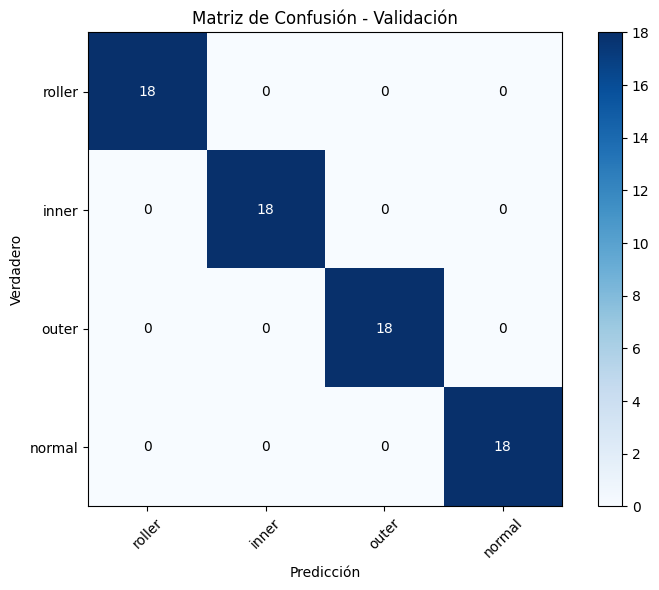

Reporte de clasificación (Prueba):
              precision    recall  f1-score   support

       inner       1.00      1.00      1.00        18
      normal       1.00      1.00      1.00        18
       outer       1.00      1.00      1.00        18
      roller       1.00      1.00      1.00        18

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72

Precisión en el conjunto de prueba: 1.00


In [25]:
rf_model = RandomForestClassifier(
    n_estimators=100,  # Número de árboles
    max_depth=None,    # Sin límite de profundidad
    random_state=42    # Reproducibilidad
)

# Entrenamiento del modelo
rf_model.fit(X_train, y_train)

# Evaluación en el conjunto de validación
y_val_pred = rf_model.predict(X_val)

# Métricas en validación
print("Reporte de clasificación (Validación):")
print(classification_report(y_val, y_val_pred))

# Matriz de confusión para validación
conf_matrix = confusion_matrix(y_val, y_val_pred, labels=y_train.unique())

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Validación")
plt.colorbar()
tick_marks = np.arange(len(y_train.unique()))
plt.xticks(tick_marks, y_train.unique(), rotation=45)
plt.yticks(tick_marks, y_train.unique())
plt.xlabel("Predicción")
plt.ylabel("Verdadero")

# Anotar valores en la matriz
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

# Evaluación final en el conjunto de prueba
y_test_pred = rf_model.predict(X_test)

# Métricas en prueba
print("Reporte de clasificación (Prueba):")
print(classification_report(y_test, y_test_pred))
print(f"Precisión en el conjunto de prueba: {accuracy_score(y_test, y_test_pred):.2f}")



### Validación cruzada para verifiar sobreajuste

In [26]:
rf_model = RandomForestClassifier(
    n_estimators=100,  # Número de árboles
    max_depth=None,     # Sin límite de profundidad
    random_state=42     # Reproducibilidad
)

# Realizar validación cruzada con 5 particiones (5-fold cross-validation)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# Mostrar resultados
print("Resultados de validación cruzada (precisión en cada partición):", cv_scores)
print("Precisión media de la validación cruzada:", np.mean(cv_scores))
print("Desviación estándar de la validación cruzada:", np.std(cv_scores))


Resultados de validación cruzada (precisión en cada partición): [1. 1. 1. 1. 1.]
Precisión media de la validación cruzada: 1.0
Desviación estándar de la validación cruzada: 0.0


#### No se confirma sobreajuste